## Initialization

In [1]:
# Libraries for data manipulation, computation, and graph
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Tensorflow for neural network
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
#checking the general information about our datafile
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


As descirbed in the instructions, there are 7.6k of photos. The csv file which stores the file names and age of the person in the photo also has around 7.6k rows of data.

In [5]:
# Using ImageDataGenerator to form small batches of images

train_datagen = ImageDataGenerator(rescale=1/255)

train_datagen_flow = train_datagen.flow_from_dataframe(dataframe= labels,
                                                       directory = '/datasets/faces/final_files',
                                                       x_col = 'file_name',
                                                       y_col='real_age',
                                                       class_mode='raw',
                                                      batch_size = 16,
                                                      target_size = (150,150),
                                                       seed = 12345)

Found 7591 validated image filenames.


In [6]:
#"picture-label" pairs can be obtained using the next() function

features, target = next(train_datagen_flow)

print(features.shape)
print(target.shape)

(16, 150, 150, 3)
(16,)


There are 16 images in both target and features dataset. Images are 150 * 150 pixels with 3 channels. 

## EDA

In [7]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Text(0, 0.5, 'Frequency')

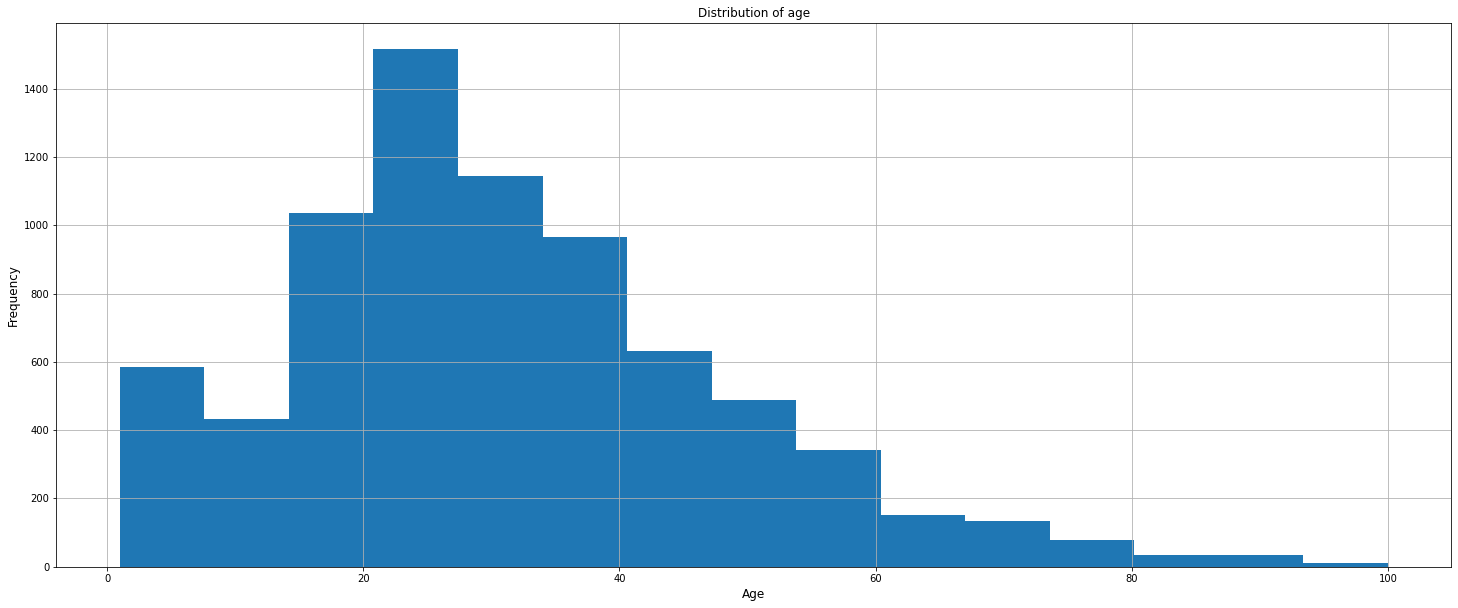

In [8]:
plt.figure(figsize=(25,10))
labels['real_age'].hist(bins=15)
plt.title('Distribution of age', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

In [9]:
labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

Text(0, 0.5, 'Count')

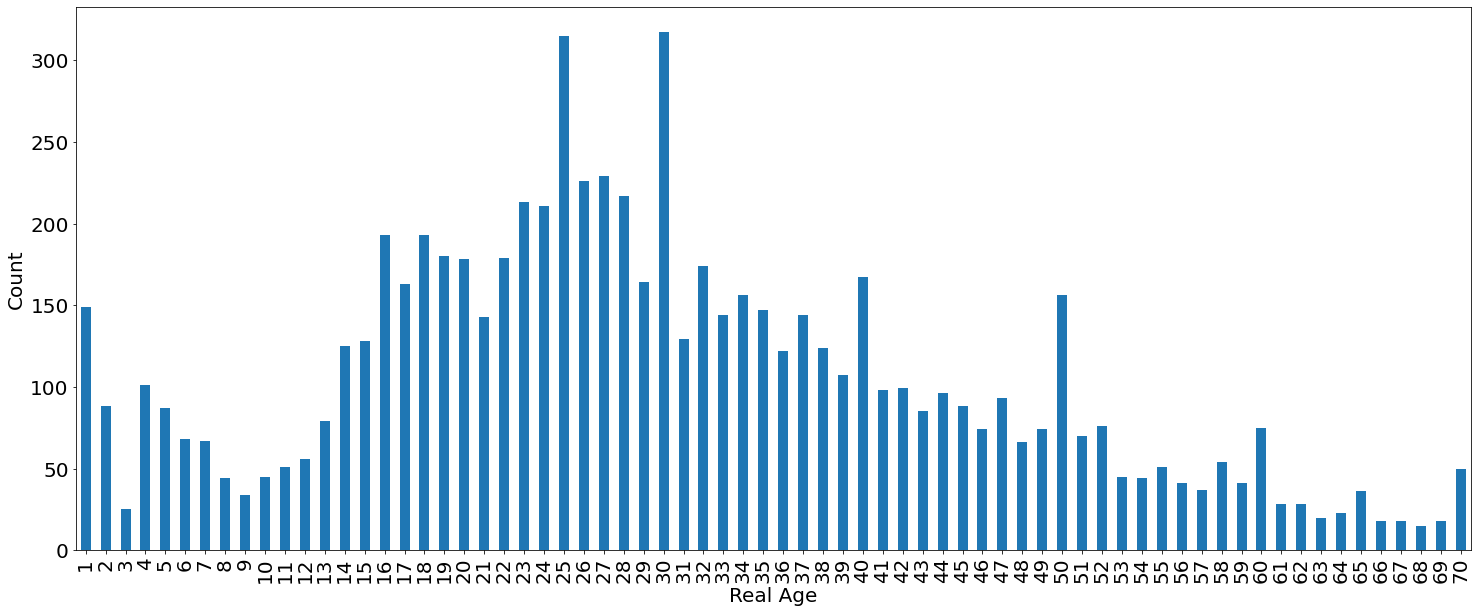

In [10]:
# Too small to display the counts all the way till 100. Zoom in to below 70 to display the counts per age
 
plt.figure(figsize=(25,10))
labels['real_age'].value_counts().sort_index(ascending=True).head(70).plot(kind='bar')
plt.tick_params(axis='both', labelsize=20, color='black')
plt.xlabel('Real Age', fontsize=20)
plt.ylabel('Count', fontsize=20)

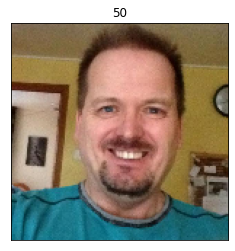

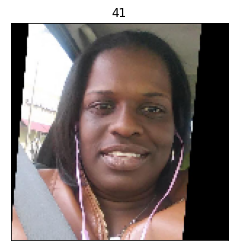

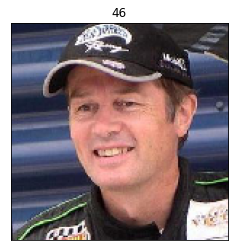

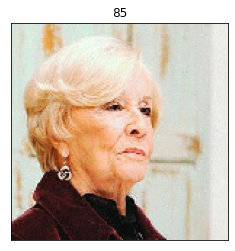

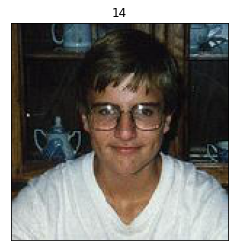

In [11]:
for age, photo in zip(target[:5], features[:5]):
    plt.figure()
    plt.title(age, fontsize=12)
    plt.imshow(photo)
    plt.yticks([])
    plt.xticks([])

### Findings

The mean age within the 7.6k is 31 years old. We can see that the data is positively skewed where outliers are leaning to the right. 

Majority of the age distributed between 16 to 40 and the count gradually decreases to 100. Therefore, I think we may not have enough images to train the model to correctly determine younger people below 16 or older people above 40. 

## Modelling

In [12]:
# Libraries for data manipulation
import pandas as pd

# Libraries for neural network and computer vision
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [13]:
def load_train(path):

    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    directory = path + 'final_files'
    
    train_datagen = ImageGenerator(validation_split=0.25,
                                   rescale = 1/255,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2)
    
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                      directory=directory,
                                                      x_col = 'file_name',
                                                      y_col = 'real_age',
                                                      target_size = (224,224),
                                                      batch_size=16,
                                                      class_mode='raw',
                                                      subset='training',
                                                      seed=12345)
    

    
    # place your code here

    return train_gen_flow

In [14]:
def load_test(path):

    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    
    directory = path + 'final_files'
    
    test_datagen = ImageGenerator(validation_split=0.25,
                                  rescale = 1/255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                      directory=directory,
                                                      x_col = 'file_name',
                                                      y_col = 'real_age',
                                                      target_size = (224,224),
                                                      batch_size=16,
                                                      class_mode='raw',
                                                      subset='validation',
                                                      seed=12345)

    return test_gen_flow

In [15]:
def create_model(input_shape):
    
    backbone = ResNet50(input_shape = input_shape,
                       weights='imagenet',
                       include_top=False)
    
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'relu'))
    model.compile(loss='mse',optimizer=optimizer, metrics=['mae'])
    """
    It defines the model
    """
    
    # place your code here

    return model

In [16]:

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)   

    """
    Trains the model given the parameters
    """
    
    # place your code here

    return model

## Prepare the Script to Run on the GPU Platform

In [17]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20

2023-12-27 11:03:38.839987: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-12-27 11:03:39.201159: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

2023-12-27 11:03:40.884969: I tensorflow/stream_executor/cuda/cuda_driver.cc:801] failed to allocate 2.65G (2844409856 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory

356/356 - 135s - loss: 273.8955 - mae: 12.1423 - val_loss: 521.6835 - val_mae: 17.8192

Epoch 2/20

356/356 - 117s - loss: 127.1002 - mae: 8.6032 - val_loss: 241.6678 - val_mae: 11.7679

Epoch 3/20

356/356 - 117s - loss: 109.9015 - mae: 8.0307 - val_loss: 89.7538 - val_mae: 7.3410

Epoch 4/20

356/356 - 117s - loss: 92.8854 - mae: 7.4231 - val_loss: 124.3051 - val_mae: 8.3053

Epoch 5/20

356/356 - 117s - loss: 85.4095 - mae: 7.1020 - val_loss: 97.3578 - val_mae: 7.2222

Epoch 6/20

356/356 - 115s - loss: 78.1064 - mae: 6.7888 - val_loss: 103.5976 - val_mae: 7.6809

Epoch 7/20

356/356 - 112s - loss: 70.2012 - mae: 6.4369 - val_loss: 109.1109 - val_mae: 7.7419

Epoch 8/20

356/356 - 112s - loss: 66.6129 - mae: 6.2864 - val_loss: 89.5475 - val_mae: 7.1775

Epoch 9/20


356/356 - 112s - loss: 61.0512 - mae: 5.9594 - val_loss: 127.9296 - val_mae: 8.2499

Epoch 10/20

356/356 - 112s - loss: 57.0675 - mae: 5.8146 - val_loss: 93.8436 - val_mae: 7.2267

Epoch 11/20

356/356 - 112s - loss: 52.3443 - mae: 5.5448 - val_loss: 76.0281 - val_mae: 6.5332

Epoch 12/20

356/356 - 118s - loss: 52.8983 - mae: 5.5743 - val_loss: 82.7000 - val_mae: 6.8517

Epoch 13/20

356/356 - 121s - loss: 45.7516 - mae: 5.2152 - val_loss: 110.4888 - val_mae: 7.5773

Epoch 14/20

356/356 - 122s - loss: 41.1680 - mae: 4.9319 - val_loss: 80.2204 - val_mae: 6.6298

Epoch 15/20

356/356 - 121s - loss: 38.5088 - mae: 4.7619 - val_loss: 85.1028 - val_mae: 6.7867


Epoch 16/20

356/356 - 121s - loss: 35.5612 - mae: 4.6128 - val_loss: 85.3801 - val_mae: 6.9973

Epoch 17/20


356/356 - 121s - loss: 34.5792 - mae: 4.5514 - val_loss: 89.6113 - val_mae: 7.1100

Epoch 18/20

356/356 - 122s - loss: 33.0647 - mae: 4.4589 - val_loss: 80.5987 - val_mae: 6.6583

Epoch 19/20

356/356 - 115s - loss: 31.9921 - mae: 4.3601 - val_loss: 84.4857 - val_mae: 6.7301

Epoch 20/20

356/356 - 115s - loss: 30.5714 - mae: 4.2673 - val_loss: 72.9609 - val_mae: 6.3076

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 30s - loss: 76.8015 - mae: 6.4050
Test MAE: 6.4050

## Conclusions

We have successfully trained our test set with a MAE below 7. Our model should be able to determine a person's age by a photo. We can leverage the age of our customers to identify purchasing habits and use the findings for targeted advertisments to the age groups. 

The age identifier also helps to identify selling alcohol to underage teens.
